In [ ]:
# Feature Extraction for "To bee or not to bee" - Conforme aux consignes
# IG.2412 & IG.2411

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import cv2
from tqdm import tqdm
from skimage import measure, feature, color, morphology

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, silhouette_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.optimize import minimize
from skimage.transform import rotate

# Configuration des chemins
DATA_DIR = "../train" 
IMAGES_DIR = os.path.join(DATA_DIR, "images")
MASKS_DIR = os.path.join(DATA_DIR, "masks")
EXCEL_FILE = os.path.join(DATA_DIR, "classif.xlsx")

# ==================== I. QUALITY CONTROL ====================

def load_classification_data():
    """Charger les données de classification depuis le fichier Excel"""
    df = pd.read_excel(EXCEL_FILE)
    print(f"Données chargées: {len(df)} insectes")
    print(df.head())
    return df

def load_image_and_mask(image_id, visualize=False, output_dir="cleaned_samples"):
    """
    I. Quality control : Charger et nettoyer une image et son masque selon les consignes :
    - Loading the mask and associated image
    - Transforming the mask into a binary image (label 1 being the insect, label 0 the background)
    - Computing the connected components of the binary mask
    - Restricting the binary mask to its connected component of highest area
    - Restricting both mask and image to the bounding box of the cleaned binary mask
    """
    image_path = os.path.join(IMAGES_DIR, f"{image_id}.jpg")
    mask_path = os.path.join(MASKS_DIR, f"binary_{image_id}.tif")

    # Vérifier l'existence des fichiers
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image non trouvée: {image_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Masque non trouvé: {mask_path}")

    # Loading the mask and associated image
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    
    # Transforming the mask into a binary image (label 1 being the insect, label 0 the background)
    mask_binary = (mask > 0).astype(np.uint8)

    # Computing the connected components of the binary mask
    labeled_mask = measure.label(mask_binary)
    props = measure.regionprops(labeled_mask)

    if not props:
        raise ValueError(f"Aucune composante connexe trouvée dans le masque pour l'image {image_id}")

    # Restricting the binary mask to its connected component of highest area
    largest_region = max(props, key=lambda x: x.area)
    cleaned_mask = (labeled_mask == largest_region.label).astype(np.uint8)

    # Restricting both mask and image to the bounding box of the cleaned binary mask
    minr, minc, maxr, maxc = largest_region.bbox
    cleaned_mask_cropped = cleaned_mask[minr:maxr, minc:maxc]
    cropped_image = image[minr:maxr, minc:maxc]

    # Visualizing the resulted images and masks in a distinct directory
    if visualize:
        os.makedirs(output_dir, exist_ok=True)
        
        # Créer une visualisation avant/après
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Image originale
        axes[0,0].imshow(image)
        axes[0,0].set_title(f"Original Image {image_id}")
        axes[0,0].axis('off')
        
        # Masque original
        axes[0,1].imshow(mask, cmap='gray')
        axes[0,1].set_title("Original Mask")
        axes[0,1].axis('off')
        
        # Image nettoyée et croppée
        axes[1,0].imshow(cropped_image)
        axes[1,0].set_title("Cleaned & Cropped Image")
        axes[1,0].axis('off')
        
        # Masque nettoyé et croppé
        axes[1,1].imshow(cleaned_mask_cropped, cmap='gray')
        axes[1,1].set_title("Cleaned & Cropped Mask")
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"quality_control_{image_id}.png"), dpi=150, bbox_inches='tight')
        plt.close()

    return cropped_image, cleaned_mask_cropped

# ==================== II. COMPUTATION OF THE BEST INSCRIBED CIRCLE ====================

def compute_best_inscribed_circle(mask):
    """
    II. Computation of the best inscribed circle selon les consignes :
    - Choosing a proper initialization relying on the centroid of the mask
    - Defining a loss function to minimize
    - Minimizing the defined loss using the minimize function of Scipy
    """
    from scipy.ndimage import distance_transform_edt
    
    mask_binary = (mask > 0).astype(int)
    if not np.any(mask_binary):
        return 0.0, (0.0, 0.0)
    
    # Distance transform pour avoir la distance au bord le plus proche
    distance_map = distance_transform_edt(mask_binary)
    
    # Choosing a proper initialization relying on the centroid of the mask
    props = measure.regionprops(mask_binary)
    if not props:
        return 0.0, (0.0, 0.0)
    
    centroid = props[0].centroid  # (y, x) - initialisation avec le centroïde
    
    # Defining a loss function to minimize
    def loss_function(coords):
        """Loss function: négatif du rayon (pour maximiser le rayon)"""
        y, x = coords
        # Vérifier les bornes
        if not (0 <= y < distance_map.shape[0] and 0 <= x < distance_map.shape[1]):
            return 1000  # Pénalité forte si hors bornes
        
        # Le rayon est la distance au bord le plus proche
        radius = distance_map[int(y), int(x)]
        return -radius  # Négatif car on veut maximiser le rayon
    
    # Minimizing the defined loss using the minimize function of Scipy
    result = minimize(
        loss_function,
        x0=[centroid[0], centroid[1]],  # Initialisation avec le centroïde
        bounds=[(0, mask_binary.shape[0]-1), (0, mask_binary.shape[1]-1)],
        method='L-BFGS-B'
    )
    
    # Extraire les résultats
    y_opt, x_opt = result.x[0], result.x[1]
    max_radius = -result.fun  # Récupérer le rayon (négatif du minimum)
    best_center = (x_opt, y_opt)  # (x, y)
    
    return float(max_radius), best_center

def visualize_inscribed_circle(image, mask, center, radius, image_id, output_dir="visual_inspection"):
    """Visualizing results efficiently selon les consignes"""
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Créer la visualisation
        vis = image.copy()
        cx, cy = int(center[0]), int(center[1])
        
        # Dessiner le cercle inscrit en vert
        vis = cv2.circle(vis, (cx, cy), int(radius), (0, 255, 0), 2)
        # Dessiner le centre en rouge
        vis = cv2.circle(vis, (cx, cy), 3, (255, 0, 0), -1)
        
        # Ajouter titre et informations
        plt.figure(figsize=(8, 6))
        plt.imshow(vis.astype(np.uint8))
        plt.title(f"Best Inscribed Circle - Image {image_id}\nRadius: {radius:.2f}, Center: ({cx}, {cy})")
        plt.axis('off')
        
        # Sauvegarder
        vis_path = os.path.join(output_dir, f"inscribed_circle_{image_id}.png")
        plt.savefig(vis_path, bbox_inches='tight', dpi=150)
        plt.close()
        
    except Exception as e:
        print(f"Erreur dans la visualisation du cercle pour {image_id}: {e}")

# ==================== III. COMPUTATION OF THE BEST SYMMETRY PLANE ====================

def rotate_image_filled(image, angle, center):
    """Rotation function selon les consignes (filled and proper rotation function from lab 1)"""
    try:
        # Convertir le centre en coordonnées pour skimage (y, x)
        center_skimage = (center[1], center[0])
        rotated = rotate(image, angle, center=center_skimage, preserve_range=True, cval=0)
        return rotated.astype(image.dtype)
    except Exception as e:
        print(f"Erreur dans la rotation: {e}")
        return image

def create_symmetric_image(image, center_x):
    """Create the symmetric of an image around a vertical line going through a point of coordinates (xc, yc)"""
    # Créer l'image symétrique par rapport à une ligne verticale passant par center_x
    symmetric_image = np.fliplr(image)
    return symmetric_image

def compute_best_symmetry_plane(image, mask, circle_center, circle_radius):
    """
    III. Computation of the best symmetry plane selon les consignes :
    - Choosing a proper initialization among rotations of the input image at different angles around the center of the best inscribed circle
    - Using the filled and proper rotation function from lab 1
    - Using your own function to create the symmetric of an image around a vertical line going through a point of coordinates (xc, yc)
    - Defining a loss function to minimize relying on the input image, its symmetric image, and the best inscribed circle
    - Minimizing the defined loss using the minimize function of Scipy
    """
    
    # Créer le masque circulaire pour limiter l'analyse à la région d'intérêt
    Y, X = np.ogrid[:mask.shape[0], :mask.shape[1]]
    cx, cy = circle_center
    circle_mask = (X - cx)**2 + (Y - cy)**2 <= circle_radius**2
    
    # Defining a loss function to minimize relying on the input image, its symmetric image, and the best inscribed circle
    def symmetry_loss_function(angle):
        """Loss function basée sur la différence entre l'image et son symétrique dans le cercle inscrit"""
        try:
            # Using the filled and proper rotation function
            rotated_image = rotate_image_filled(image, angle[0], circle_center)
            
            # Using your own function to create the symmetric of an image around a vertical line
            symmetric_image = create_symmetric_image(rotated_image, cx)
            
            # Calculer la différence dans la zone du cercle inscrit
            if np.any(circle_mask):
                # Convertir en float pour éviter les problèmes de débordement
                diff = np.sum((rotated_image[circle_mask].astype(float) - symmetric_image[circle_mask].astype(float))**2)
                return diff / np.sum(circle_mask)
            else:
                return 1000  # Pénalité si pas de masque circulaire
        except Exception as e:
            return 1000  # Pénalité en cas d'erreur
    
    # Choosing a proper initialization among rotations of the input image at different angles
    # Tester plusieurs angles initiaux et prendre le meilleur
    initial_angles = [-30, -15, 0, 15, 30]
    best_result = None
    best_loss = float('inf')
    
    for init_angle in initial_angles:
        try:
            # Minimizing the defined loss using the minimize function of Scipy
            result = minimize(
                symmetry_loss_function,
                x0=[init_angle],
                bounds=[(-45, 45)],
                method='L-BFGS-B'
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_result = result
        except:
            continue
    
    if best_result is not None:
        best_angle = best_result.x[0]
        min_loss = best_result.fun
    else:
        best_angle = 0.0
        min_loss = 1000.0
    
    return float(min_loss), float(best_angle)

def visualize_symmetry_plane(image, mask, center, angle, image_id, output_dir="visual_symmetry"):
    """Visualizing results efficiently pour la symétrie"""
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Rotation de l'image avec l'angle optimal
        rotated_img = rotate_image_filled(image, angle, center)
        
        # Créer la visualisation
        vis_rotated = rotated_img.copy()
        
        # Dessiner l'axe vertical au centre
        cx = int(center[0])
        h, w = vis_rotated.shape[:2]
        
        # Ligne verticale cyan
        vis_rotated = cv2.line(vis_rotated, (cx, 0), (cx, h-1), (0, 255, 255), 2)
        
        # Utiliser matplotlib pour ajouter le titre
        plt.figure(figsize=(8, 6))
        plt.imshow(vis_rotated.astype(np.uint8))
        plt.title(f"Best Symmetry Plane - Image {image_id}\nOptimal angle: {angle:.2f}°")
        plt.axis('off')
        
        # Sauvegarder
        vis_path = os.path.join(output_dir, f"symmetry_plane_{image_id}.png")
        plt.savefig(vis_path, bbox_inches='tight', dpi=150)
        plt.close()
        
    except Exception as e:
        print(f"Erreur dans la visualisation de symétrie pour {image_id}: {e}")

# ==================== FEATURES EXTRACTION ====================

def extract_shape_features(mask):
    """Extraire les caractéristiques de forme et symétrie à partir du masque"""
    mask_binary = (mask > 0).astype(int)
    
    props = measure.regionprops(mask_binary)
    if not props:
        return {
            'area': 0, 'perimeter': 0, 'eccentricity': 0, 'solidity': 0, 
            'extent': 0, 'aspect_ratio': 0, 'horizontal_symmetry': 0
        }
    
    prop = props[0]
    
    # Caractéristiques de forme
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    solidity = prop.solidity
    extent = prop.extent
    
    # Aspect ratio
    major_axis_length = prop.major_axis_length
    minor_axis_length = prop.minor_axis_length
    aspect_ratio = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0
    
    # Mesure de symétrie horizontale simple
    height, width = mask_binary.shape
    if width >= 2:
        mid = width // 2
        left_half = mask_binary[:, :mid]
        right_half = mask_binary[:, width-mid:]
        right_half_flipped = np.fliplr(right_half)
        
        min_width = min(left_half.shape[1], right_half_flipped.shape[1])
        if min_width > 0:
            intersection = np.sum(left_half[:, :min_width] & right_half_flipped[:, :min_width])
            union = np.sum(left_half[:, :min_width] | right_half_flipped[:, :min_width])
            horizontal_symmetry = intersection / union if union > 0 else 0
        else:
            horizontal_symmetry = 0
    else:
        horizontal_symmetry = 0
    
    return {
        'area': float(area),
        'perimeter': float(perimeter),
        'eccentricity': float(eccentricity),
        'solidity': float(solidity),
        'extent': float(extent),
        'aspect_ratio': float(aspect_ratio),
        'horizontal_symmetry': float(horizontal_symmetry)
    }

def calculate_bug_ratio(mask):
    """Calculer le ratio de pixels de l'insecte par rapport à l'image totale"""
    bug_pixels = np.sum(mask > 0)
    total_pixels = mask.size
    ratio = bug_pixels / total_pixels if total_pixels > 0 else 0
    return float(ratio)

def extract_color_features(image, mask):
    """Extraire les caractéristiques de couleur (RGB) à partir de l'image et du masque"""
    mask_bool = mask > 0
    
    if not np.any(mask_bool):
        return {f'{color}_{stat}': 0.0 for color in ['r', 'g', 'b'] 
                for stat in ['min', 'max', 'mean', 'median', 'std']}
    
    # Extraire les pixels de l'insecte pour chaque canal
    r_channel = image[:, :, 0][mask_bool]
    g_channel = image[:, :, 1][mask_bool]
    b_channel = image[:, :, 2][mask_bool]
    
    def get_channel_stats(channel):
        if len(channel) == 0:
            return {'min': 0, 'max': 0, 'mean': 0, 'median': 0, 'std': 0}
        return {
            'min': float(np.min(channel)),
            'max': float(np.max(channel)),
            'mean': float(np.mean(channel)),
            'median': float(np.median(channel)),
            'std': float(np.std(channel))
        }
    
    # Caractéristiques pour chaque canal
    r_stats = get_channel_stats(r_channel)
    g_stats = get_channel_stats(g_channel)
    b_stats = get_channel_stats(b_channel)
    
    color_features = {}
    for stat in ['min', 'max', 'mean', 'median', 'std']:
        color_features[f'r_{stat}'] = r_stats[stat]
        color_features[f'g_{stat}'] = g_stats[stat]
        color_features[f'b_{stat}'] = b_stats[stat]
    
    return color_features

def extract_additional_features(image, mask):
    """Extraire des caractéristiques additionnelles au choix"""
    mask_bool = mask > 0
    
    if not np.any(mask_bool):
        return {
            'texture_entropy': 0.0, 'texture_energy': 0.0,
            'hu_moment1': 0.0, 'hu_moment2': 0.0, 'hu_moment3': 0.0, 'hu_moment4': 0.0
        }
    
    # Feature 1: Texture (Local Binary Pattern)
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        radius = min(3, min(image.shape[:2]) // 4)
        n_points = 8 * radius
        
        if radius > 0:
            lbp = feature.local_binary_pattern(gray, n_points, radius, method='uniform')
            lbp_bug = lbp[mask_bool]
            
            if len(lbp_bug) > 0:
                n_bins = int(n_points + 2)
                hist, _ = np.histogram(lbp_bug, bins=n_bins, range=(0, n_bins), density=True)
                hist = hist + 1e-10
                texture_entropy = -np.sum(hist * np.log2(hist))
                texture_energy = np.sum(hist ** 2)
            else:
                texture_entropy = 0.0
                texture_energy = 0.0
        else:
            texture_entropy = 0.0
            texture_energy = 0.0
    except:
        texture_entropy = 0.0
        texture_energy = 0.0
    
    # Feature 2: Moments de Hu
    try:
        moments = cv2.moments(mask.astype(np.uint8))
        hu_moments = cv2.HuMoments(moments).flatten()
        
        hu_moments_safe = []
        for moment in hu_moments[:4]:
            if abs(moment) < 1e-10:
                hu_moments_safe.append(0.0)
            else:
                hu_moments_safe.append(-np.sign(moment) * np.log10(abs(moment)))
        
        while len(hu_moments_safe) < 4:
            hu_moments_safe.append(0.0)
    except:
        hu_moments_safe = [0.0, 0.0, 0.0, 0.0]
    
    return {
        'texture_entropy': float(texture_entropy),
        'texture_energy': float(texture_energy),
        'hu_moment1': float(hu_moments_safe[0]),
        'hu_moment2': float(hu_moments_safe[1]),
        'hu_moment3': float(hu_moments_safe[2]),
        'hu_moment4': float(hu_moments_safe[3])
    }

# ==================== MAIN PROCESSING ====================

def extract_all_features(image_id):
    """Extraire toutes les caractéristiques pour une image donnée selon les consignes"""
    try:
        # I. Quality control
        image, mask = load_image_and_mask(image_id, visualize=True)
        
        if image is None or mask is None or image.size == 0 or mask.size == 0:
            raise ValueError(f"Problème avec l'image ou le masque pour {image_id}")
        
        # Extraire les caractéristiques de base
        shape_features = extract_shape_features(mask)
        bug_ratio = calculate_bug_ratio(mask)
        color_features = extract_color_features(image, mask)
        additional_features = extract_additional_features(image, mask)
        
        # II. Computation of the best inscribed circle
        max_radius, circle_center = compute_best_inscribed_circle(mask)
        
        # Visualiser le cercle inscrit
        if max_radius > 1:  # Seulement si le cercle est valide
            visualize_inscribed_circle(image, mask, circle_center, max_radius, image_id)
        
        # III. Computation of the best symmetry plane
        if max_radius > 5:  # Seulement si le cercle est assez grand
            symmetry_score, symmetry_angle = compute_best_symmetry_plane(image, mask, circle_center, max_radius)
            
            # Visualiser l'axe de symétrie
            visualize_symmetry_plane(image, mask, circle_center, symmetry_angle, image_id)
        else:
            symmetry_score = 0.0
            symmetry_angle = 0.0
        
        # Combiner toutes les caractéristiques
        features = {
            'image_id': int(image_id),
            'bug_ratio': bug_ratio,
            'max_inscribed_radius': max_radius,
            'symmetry_score': symmetry_score,
            'symmetry_angle': symmetry_angle,  # AJOUT de l'angle dans les features
            **shape_features,
            **color_features,
            **additional_features
        }
        
        return features
        
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_id}: {e}")
        return create_default_features(image_id)

def create_default_features(image_id):
    """Créer un ensemble de caractéristiques par défaut"""
    return {
        'image_id': int(image_id),
        'bug_ratio': 0.0,
        'max_inscribed_radius': 0.0,
        'symmetry_score': 0.0,
        'symmetry_angle': 0.0,  # AJOUT de l'angle
        'area': 0.0, 'perimeter': 0.0, 'eccentricity': 0.0, 'solidity': 0.0,
        'extent': 0.0, 'aspect_ratio': 0.0, 'horizontal_symmetry': 0.0,
        **{f'{color}_{stat}': 0.0 for color in ['r', 'g', 'b'] 
           for stat in ['min', 'max', 'mean', 'median', 'std']},
        'texture_entropy': 0.0, 'texture_energy': 0.0,
        'hu_moment1': 0.0, 'hu_moment2': 0.0, 'hu_moment3': 0.0, 'hu_moment4': 0.0
    }

def extract_features_for_all_images(df):
    """Extraire les caractéristiques pour toutes les images"""
    all_features = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraction des caractéristiques"):
        image_id = row['ID']
        try:
            features = extract_all_features(image_id)
            
            # Ajouter les étiquettes de classe
            features['bug_type'] = row['bug type']
            if 'species' in row:
                features['species'] = row['species']
            
            all_features.append(features)
            
        except Exception as e:
            print(f"Erreur lors du traitement de l'image {image_id}: {e}")
            default_features = create_default_features(image_id)
            default_features['bug_type'] = row['bug type']
            if 'species' in row:
                default_features['species'] = row['species']
            all_features.append(default_features)
    
    return pd.DataFrame(all_features)

def normalize_features(features_df):
    """Normaliser les caractéristiques"""
    non_numeric_cols = ['image_id', 'bug_type', 'species']
    existing_non_numeric = [col for col in non_numeric_cols if col in features_df.columns]
    numeric_cols = [col for col in features_df.columns if col not in existing_non_numeric]
    
    print(f"Colonnes numériques détectées: {len(numeric_cols)}")
    
    if not numeric_cols:
        raise ValueError("Aucune colonne numérique trouvée pour la normalisation.")
    
    numeric_data = features_df[numeric_cols]
    numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    scaler = StandardScaler()
    features_df_normalized = features_df.copy()
    features_df_normalized[numeric_cols] = scaler.fit_transform(numeric_data)
    
    return features_df_normalized, scaler

# ==================== EXECUTION ====================

if __name__ == "__main__":
    print("=== Début de l'extraction selon les consignes du projet ===")
    
    # Créer les dossiers de sortie
    os.makedirs("cleaned_samples", exist_ok=True)
    os.makedirs("visual_inspection", exist_ok=True)
    os.makedirs("visual_symmetry", exist_ok=True)
    
    try:
        # Charger les données
        classification_df = load_classification_data()
        
        # I. Quality control + II. Best inscribed circle + III. Best symmetry plane + Features extraction
        print("Extraction des caractéristiques selon les consignes...")
        features_df = extract_features_for_all_images(classification_df)
        
        if features_df.empty:
            raise ValueError("Aucune caractéristique extraite!")
        
        print(f"Caractéristiques extraites pour {len(features_df)} images")
        print(f"Colonnes: {list(features_df.columns)}")
        
        # Vérifier la présence de l'angle de symétrie
        if 'symmetry_angle' in features_df.columns:
            print(f"Angles de symétrie - Min: {features_df['symmetry_angle'].min():.2f}°, Max: {features_df['symmetry_angle'].max():.2f}°")
            print(f"Nombre d'images avec angle non-nul: {sum(features_df['symmetry_angle'] != 0)}")
        
        # Sauvegarder les caractéristiques brutes
        features_df.to_csv("features_raw.csv", index=False)
        print("Caractéristiques brutes sauvegardées dans 'features_raw.csv'")
        
        # Normaliser
        normalized_features_df, scaler = normalize_features(features_df)
        normalized_features_df.to_csv("features_normalized.csv", index=False)
        joblib.dump(scaler, "scaler.pkl")
        print("Caractéristiques normalisées sauvegardées dans 'features_normalized.csv'")
        
        # Statistiques finales
        print(f"\n=== RÉSUMÉ ===")
        print(f"Images traitées: {len(normalized_features_df)}")
        print(f"Caractéristiques par image: {len([col for col in normalized_features_df.columns if col not in ['image_id', 'bug_type', 'species']])}")
        
        if 'bug_type' in normalized_features_df.columns:
            print(f"\nRépartition

Début de l'extraction des caractéristiques...
Données chargées: 250 insectes
   ID bug type         species
0   1      Bee  Apis mellifera
1   2      Bee  Apis mellifera
2   3      Bee  Apis mellifera
3   4      Bee  Apis mellifera
4   5      Bee  Apis mellifera
Extraction des caractéristiques...


Extraction des caractéristiques:  48%|████▊     | 121/250 [11:21<12:06,  5.63s/it]


KeyboardInterrupt: 

Données chargées: 249 échantillons avec 32 caractéristiques


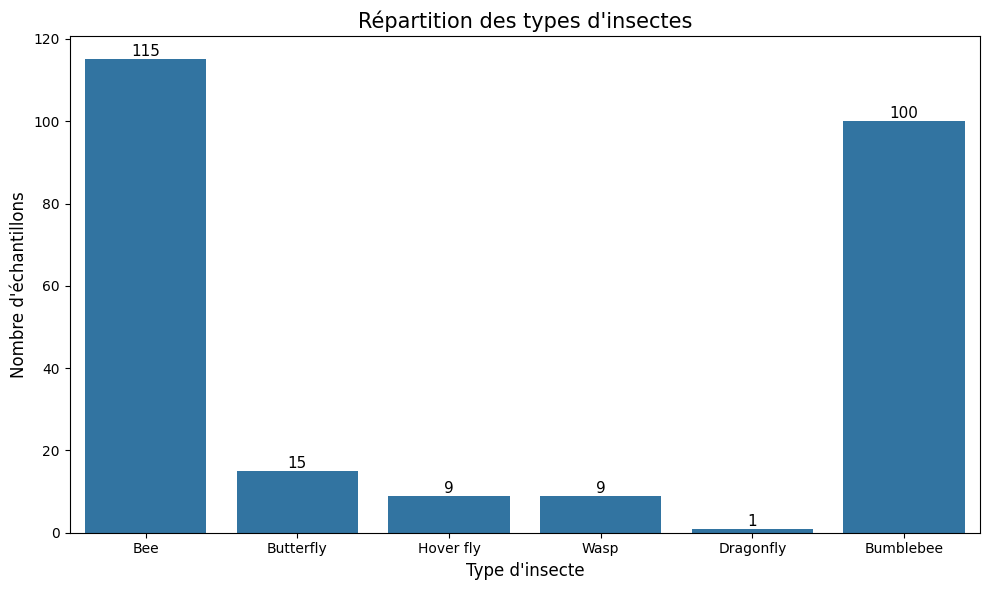

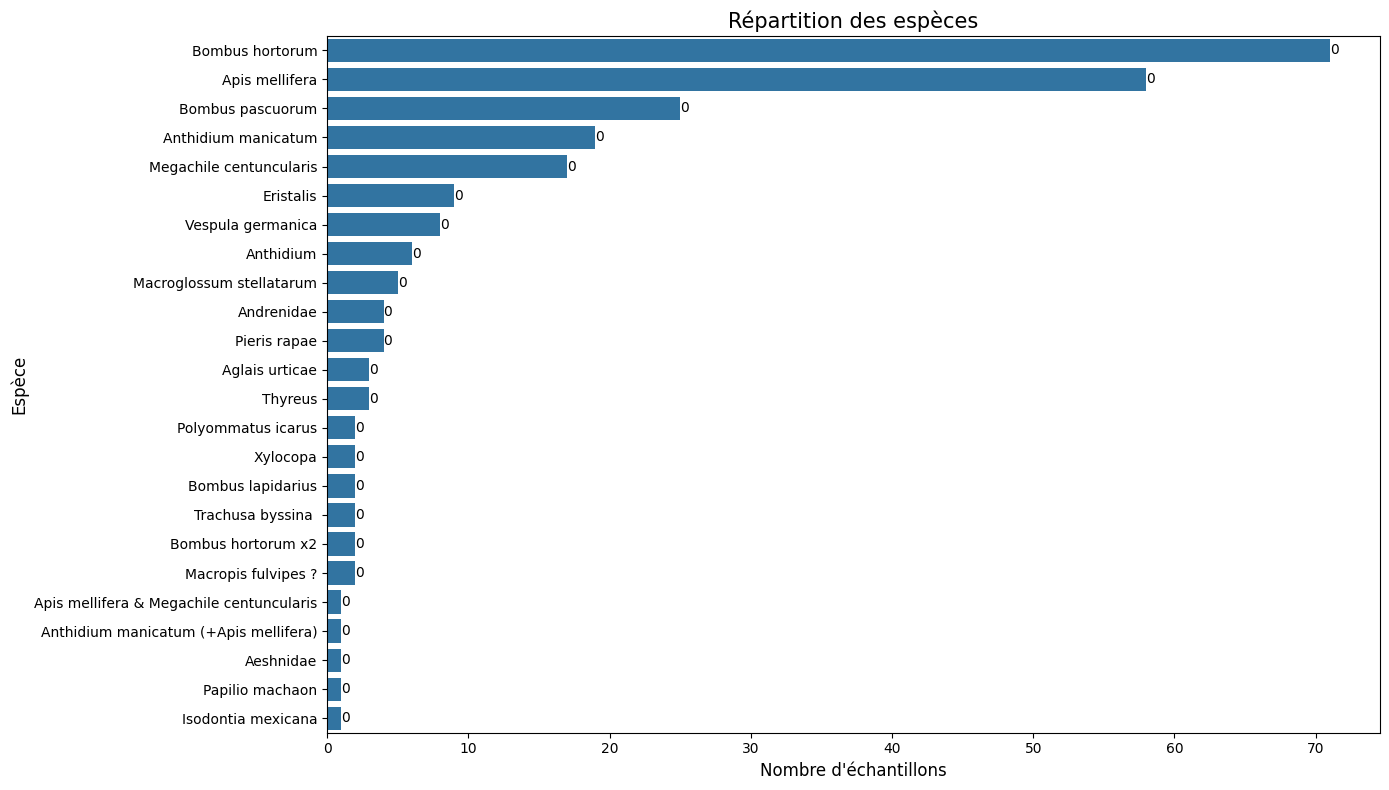

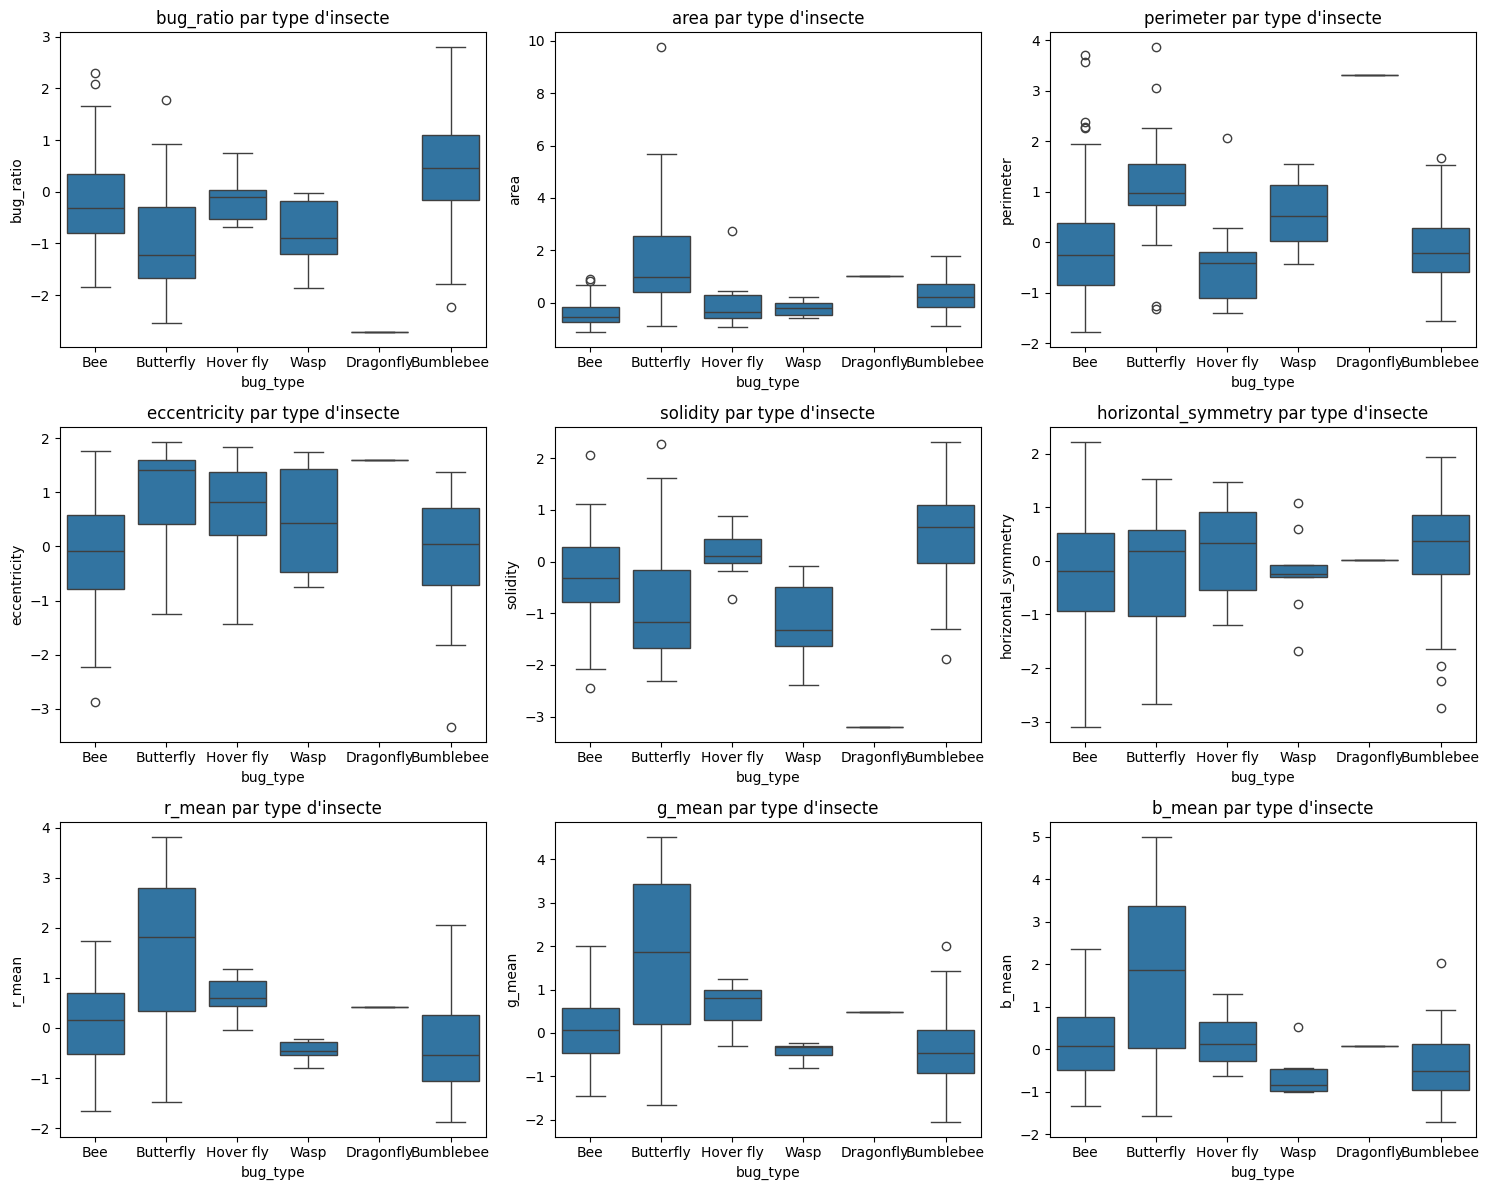

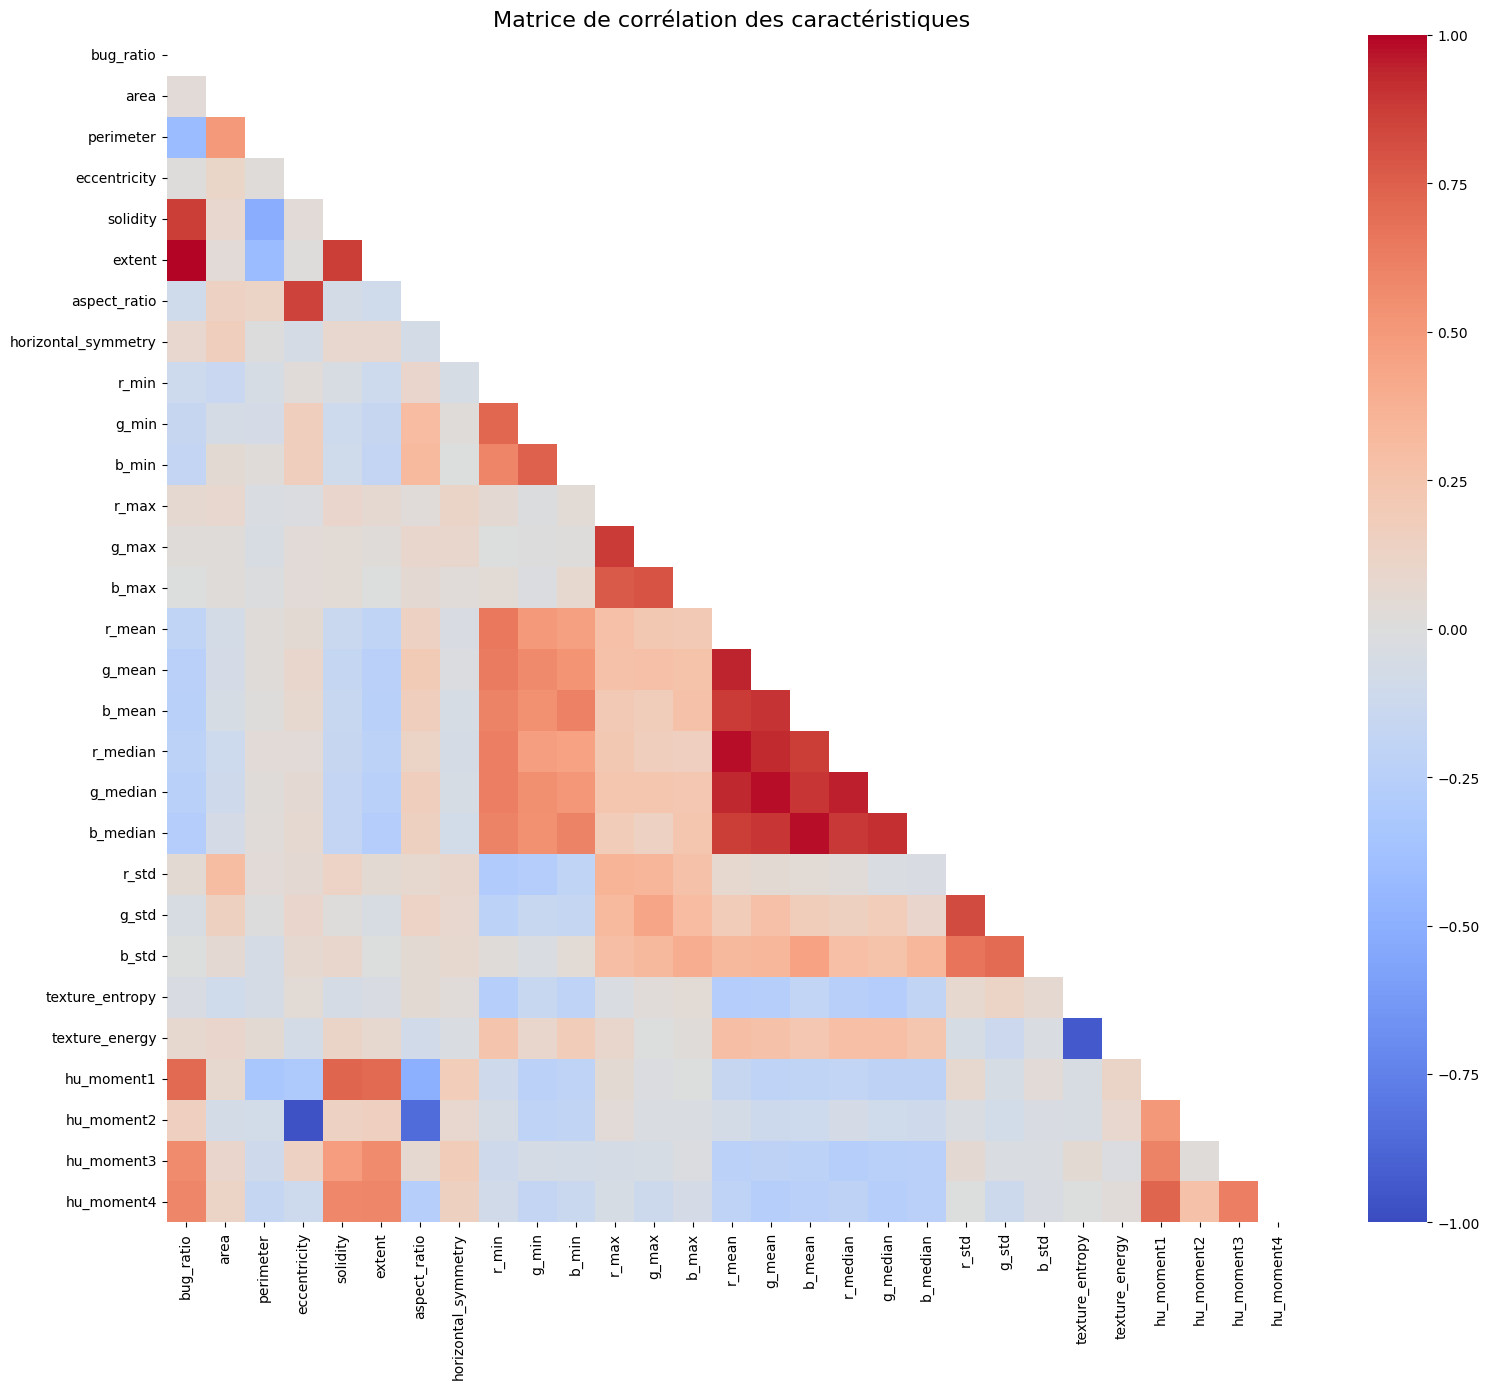

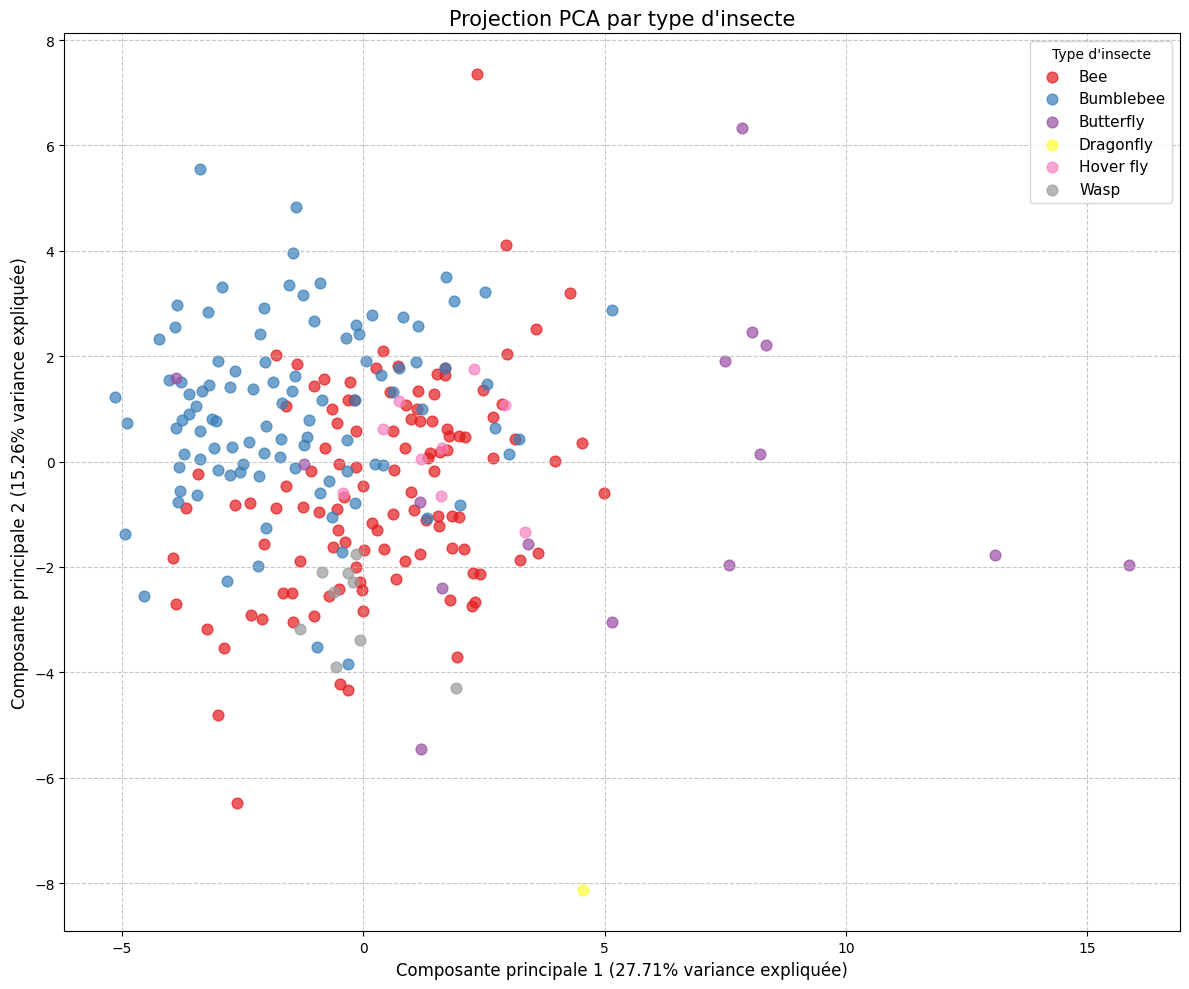

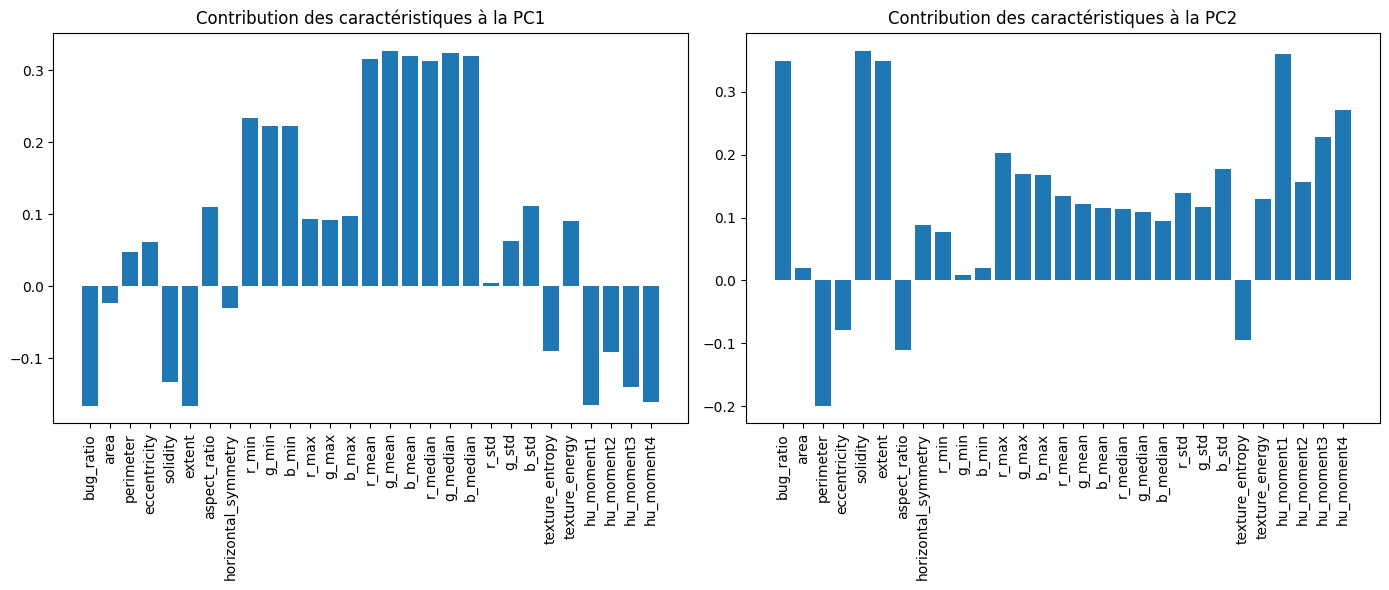

Calcul de t-SNE en cours...


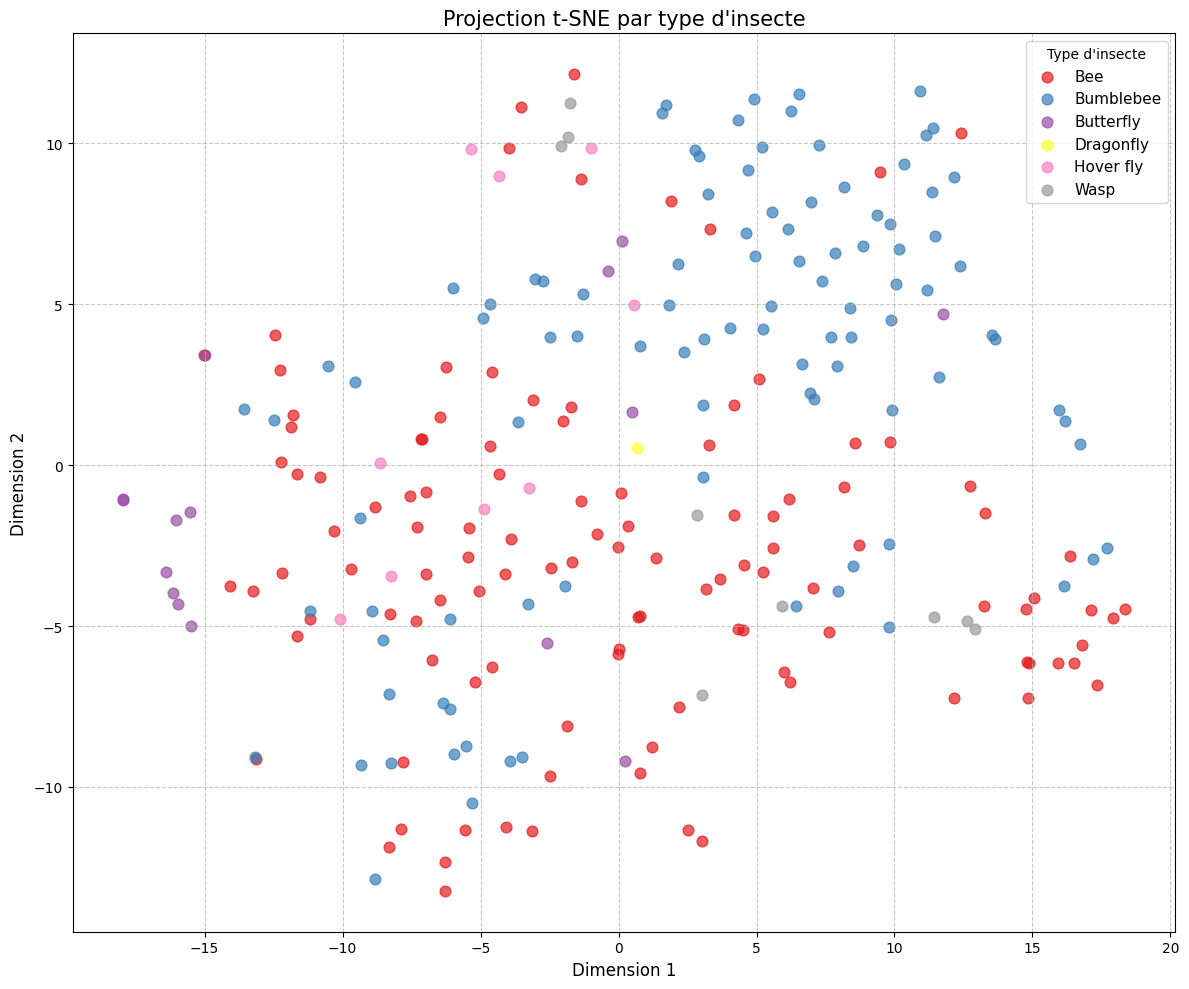

Calcul de UMAP en cours...


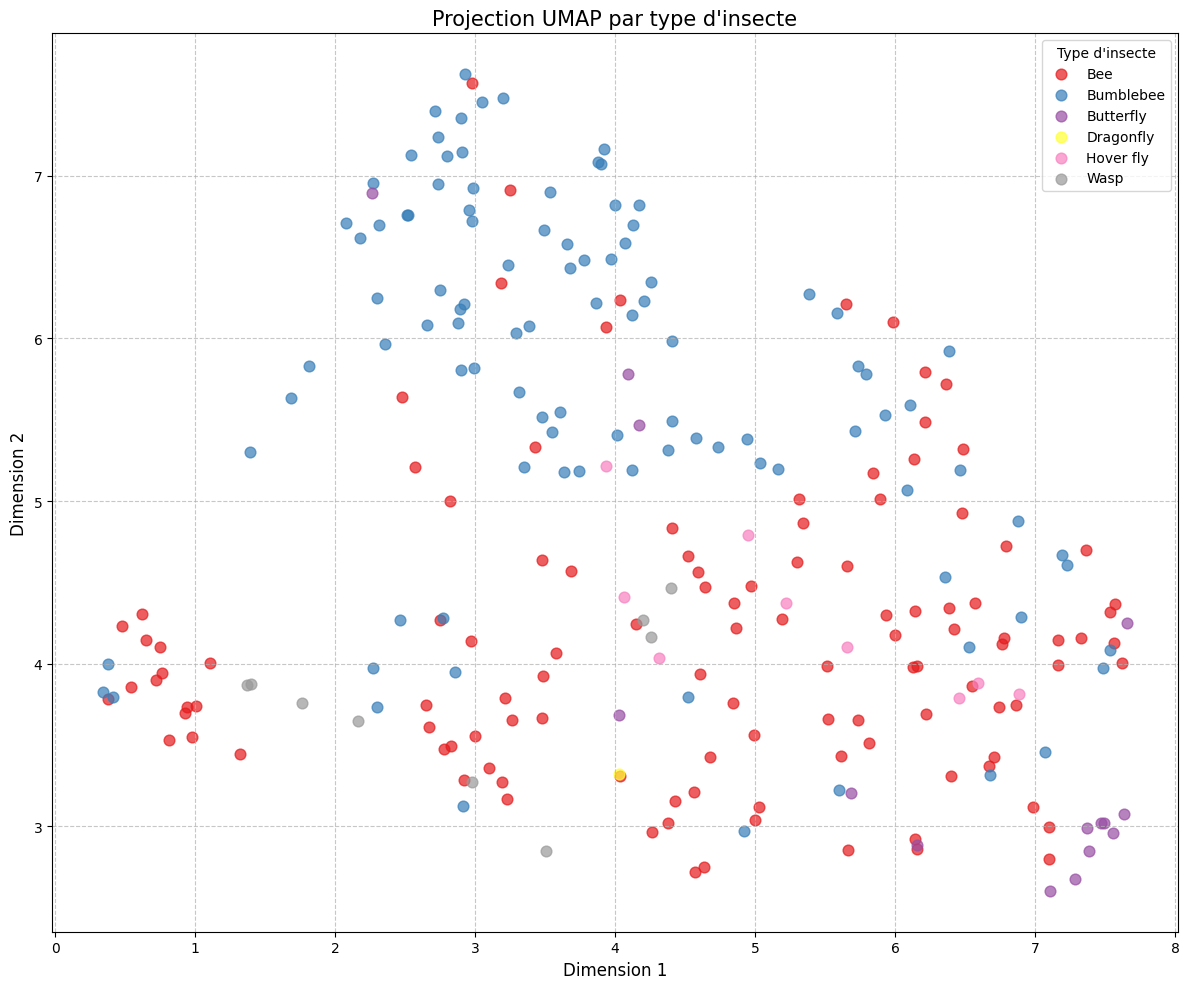

Calcul de ISOMAP en cours...


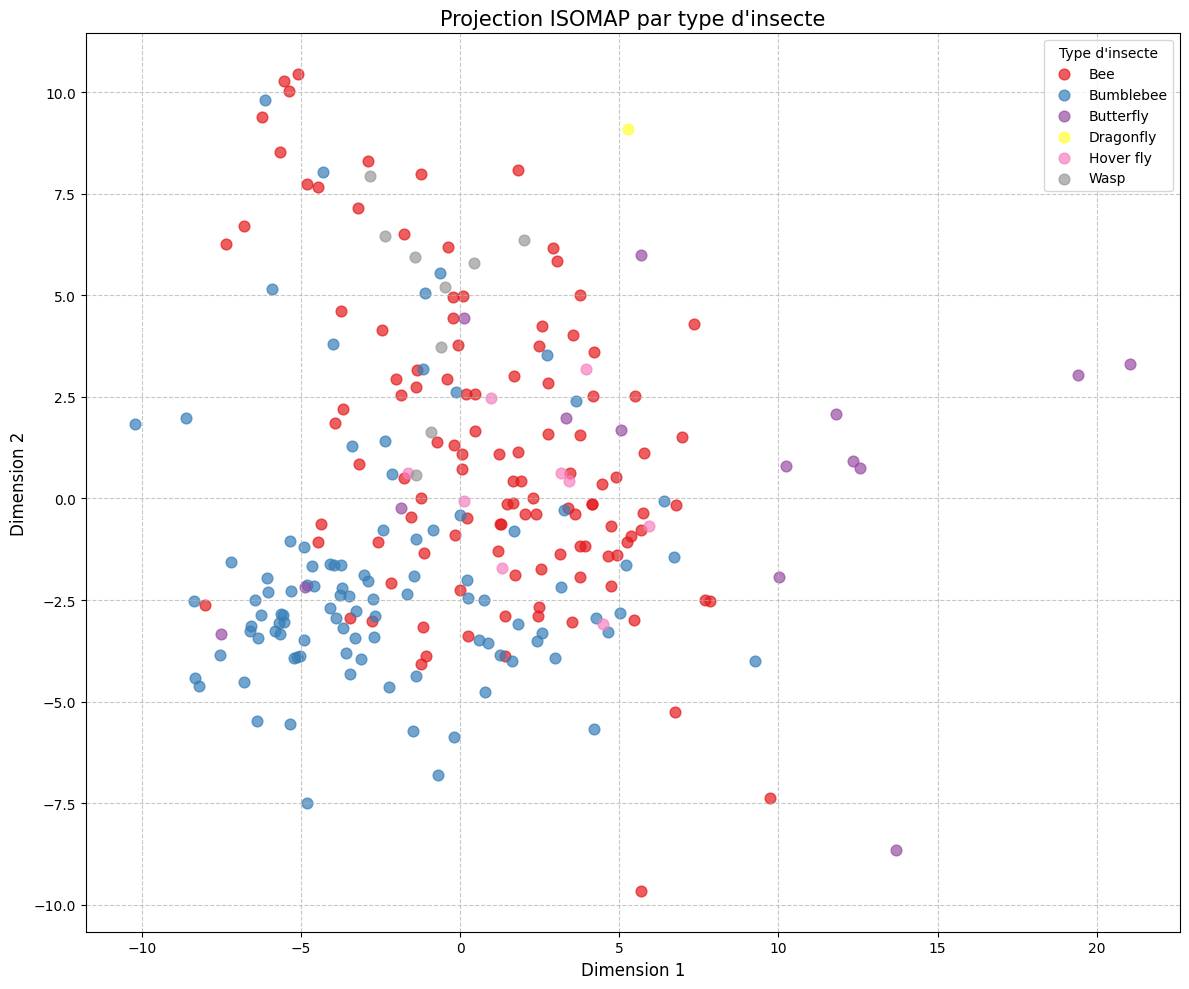

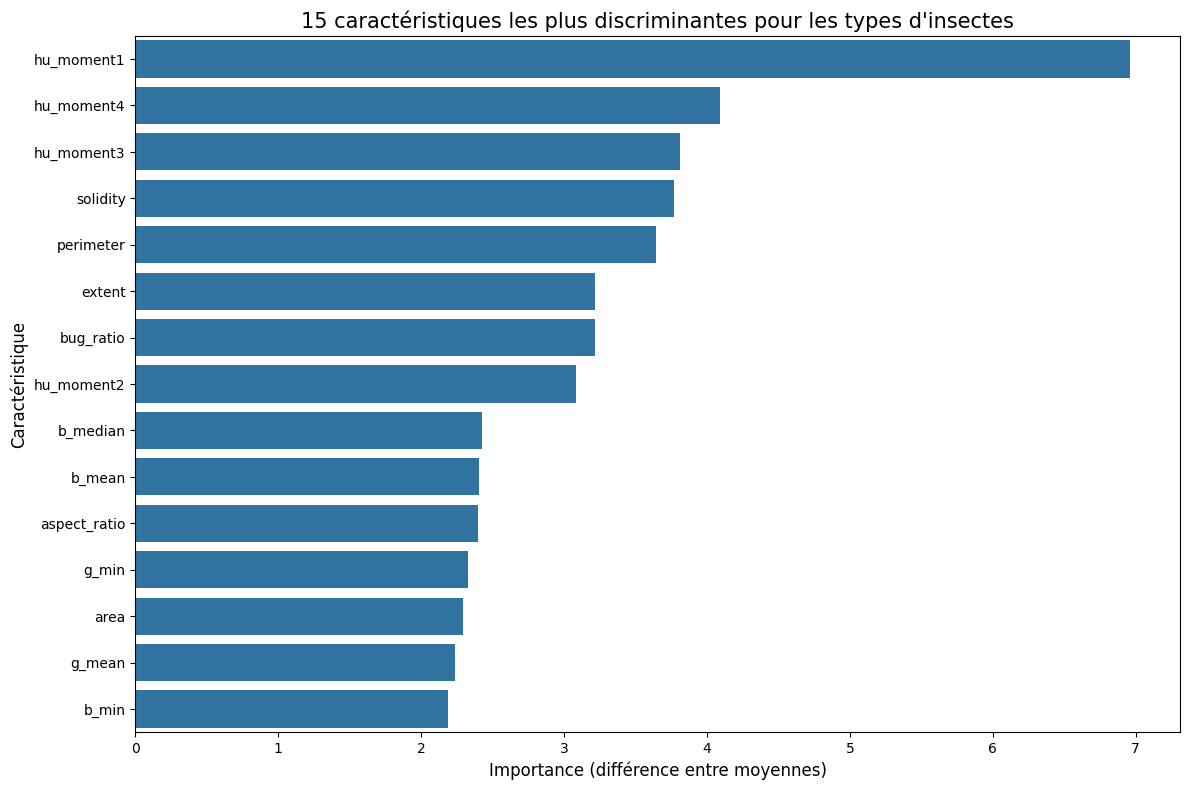

Analyse et visualisation des données terminées.
Les images ont été sauvegardées au format PNG pour le rapport.


In [ ]:
# Charger les caractéristiques normalisées
features_df = pd.read_csv('features_normalized.csv')
print(f"Données chargées: {features_df.shape[0]} échantillons avec {features_df.shape[1]} caractéristiques")

# 1. Distribution des classes
# -----------------------------------------------

# Visualisation de la répartition des types d'insectes
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=features_df, x='bug_type')
ax.set_title('Répartition des types d\'insectes', fontsize=15)
ax.set_xlabel('Type d\'insecte', fontsize=12)
ax.set_ylabel('Nombre d\'échantillons', fontsize=12)

# Ajouter les valeurs sur les barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('visualization/bug_type_distribution.png', dpi=300)
plt.show()

# Visualisation de la répartition des espèces
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=features_df, y='species', order=features_df['species'].value_counts().index)
ax.set_title('Répartition des espèces', fontsize=15)
ax.set_xlabel('Nombre d\'échantillons', fontsize=12)
ax.set_ylabel('Espèce', fontsize=12)

# Ajouter les valeurs sur les barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualization/species_distribution.png', dpi=300)
plt.show()

# 2. Visualisation des caractéristiques clés par type d'insecte
# -----------------------------------------------

# Sélectionner quelques caractéristiques clés pour les boxplots
key_features = ['bug_ratio', 'area', 'perimeter', 'eccentricity', 'solidity', 
                'horizontal_symmetry', 'r_mean', 'g_mean', 'b_mean']

# Créer des boxplots pour chaque caractéristique clé
plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='bug_type', y=feature, data=features_df)
    plt.title(f'{feature} par type d\'insecte')
    plt.tight_layout()

plt.savefig('visualization/key_features_boxplot.png', dpi=300)
plt.show()

# 3. Matrice de corrélation entre les caractéristiques
# -----------------------------------------------

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'image_id']

# Calculer la matrice de corrélation
correlation_matrix = features_df[numeric_cols].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(16, 14))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation des caractéristiques', fontsize=16)
plt.tight_layout()
plt.savefig('visualization/correlation_matrix.png', dpi=300)
plt.show()

# 4. PCA - Projection linéaire en 2D
# -----------------------------------------------

# Préparer les données pour PCA
X = features_df[numeric_cols].values
y = features_df['bug_type'].values
species = features_df['species'].values

# Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualiser les résultats de PCA
plt.figure(figsize=(12, 10))

# Obtenir les types uniques et créer une palette de couleurs
unique_types = np.unique(y)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_types)))

# Par type d'insecte avec scatter plot par groupe
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.title('Projection PCA par type d\'insecte', fontsize=15)
plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]:.2%} variance expliquée)', fontsize=12)
plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]:.2%} variance expliquée)', fontsize=12)
plt.legend(title='Type d\'insecte', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualization/pca_projection.png', dpi=300)
plt.show()

# Visualiser les loadings de PCA (contribution des caractéristiques)
plt.figure(figsize=(14, 6))
loadings = pca.components_.T
feature_names = numeric_cols

# Créer un graphique des loadings pour les deux premières composantes
plt.subplot(1, 2, 1)
indices = np.arange(len(feature_names))
plt.bar(indices, loadings[:, 0])
plt.xticks(indices, feature_names, rotation=90)
plt.title('Contribution des caractéristiques à la PC1')

plt.subplot(1, 2, 2)
plt.bar(indices, loadings[:, 1])
plt.xticks(indices, feature_names, rotation=90)
plt.title('Contribution des caractéristiques à la PC2')

plt.tight_layout()
plt.savefig('visualization/pca_loadings.png', dpi=300)
plt.show()

# 5. t-SNE - Projection non linéaire en 2D (méthode 1)
# -----------------------------------------------

# Appliquer t-SNE (peut prendre un peu de temps)
print("Calcul de t-SNE en cours...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Visualiser les résultats de t-SNE
plt.figure(figsize=(12, 10))

# Par type d'insecte avec scatter plot par groupe
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.title('Projection t-SNE par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.legend(title='Type d\'insecte', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualization/tsne_projection.png', dpi=300)
plt.show()

# 6. UMAP - Projection non linéaire en 2D (méthode 2)
# -----------------------------------------------

# Appliquer UMAP
print("Calcul de UMAP en cours...")
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# Visualiser les résultats de UMAP
plt.figure(figsize=(12, 10))
scatter = None
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    scatter = plt.scatter(X_umap[mask, 0], X_umap[mask, 1], c=[colors[i]], label=bug_type, alpha=0.7, s=60)

plt.legend(title='Type d\'insecte')
plt.title('Projection UMAP par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
# plt.colorbar(scatter, label='Type d\'insecte', ticks=[0, 1, 2])  # Optionally remove or fix this line, as colorbar does not make sense for categorical colors
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualization/umap_projection.png', dpi=300)
plt.show()

# 7. ISOMAP - Projection non linéaire en 2D (alternative)
# -----------------------------------------------

# Appliquer ISOMAP
print("Calcul de ISOMAP en cours...")
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)
# Visualiser les résultats de ISOMAP
plt.figure(figsize=(12, 10))
scatter = None
for i, bug_type in enumerate(unique_types):
    mask = y == bug_type
    scatter = plt.scatter(X_isomap[mask, 0], X_isomap[mask, 1], c=[colors[i]], label=bug_type, alpha=0.7, s=60)
plt.legend(title='Type d\'insecte')
plt.title('Projection ISOMAP par type d\'insecte', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
# plt.colorbar(scatter, label='Type d\'insecte', ticks=[0, 1, 2])  # Optionally remove or fix this line, as colorbar does not make sense for categorical colors
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualization/isomap_projection.png', dpi=300)
plt.show()
plt.show()

# 8. Analyse de l'importance des caractéristiques pour la séparation des classes
# -----------------------------------------------

# Calculer la moyenne des caractéristiques par type d'insecte
feature_importance = pd.DataFrame()
bug_types = features_df['bug_type'].unique()

for feature in numeric_cols:
    values = []
    for bug_type in bug_types:
        avg_value = features_df[features_df['bug_type'] == bug_type][feature].mean()
        values.append(avg_value)
    
    # Calculer l'écart entre les moyennes (max - min)
    feature_importance.loc[feature, 'importance'] = max(values) - min(values)

# Trier par importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualiser les 15 caractéristiques les plus importantes
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance['importance'].head(15).values, 
            y=feature_importance.head(15).index)
plt.title('15 caractéristiques les plus discriminantes pour les types d\'insectes', fontsize=15)
plt.xlabel('Importance (différence entre moyennes)', fontsize=12)
plt.ylabel('Caractéristique', fontsize=12)
plt.tight_layout()
plt.savefig('visualization/feature_importance.png', dpi=300)
plt.show()

print("Analyse et visualisation des données terminées.")
print("Les images ont été sauvegardées au format PNG pour le rapport.")

In [ ]:
# 1. Chargement des données
features_df = pd.read_csv("features_normalized.csv")

# Supprimer les classes trop rares (< 2 exemples)
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_df = features_df[features_df['bug_type'].isin(valid_classes)]

# Refaire X et y à partir du DataFrame filtré
X = filtered_df.drop(columns=['image_id', 'bug_type', 'species'])
y = filtered_df['bug_type']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # à faire avant train_test_split
joblib.dump(scaler, "scaler.joblib")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 2. Méthodes supervisées simples
print("K-Nearest Neighbors")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

print("Logistic Regression")
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# 3. Méthode d'ensemble
print("Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 4. Clustering (non supervisé)
print("KMeans clustering")
kmeans = KMeans(n_clusters=len(np.unique(y_encoded)), random_state=42)
kmeans_labels = kmeans.fit_predict(X)
print("Silhouette Score (KMeans):", silhouette_score(X, kmeans_labels))

print("DBSCAN clustering")
dbscan = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
# Vérifier que DBSCAN ne met pas tout en -1
if len(set(dbscan_labels)) > 1:
    print("Silhouette Score (DBSCAN):", silhouette_score(X, dbscan_labels))
else:
    print("DBSCAN n'a trouvé qu'un seul cluster.")

# 5. Recherche d'hyperparamètres : SVM + GridSearch
print("SVM avec GridSearchCV")
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm.fit(X_train, y_train)
print("Best Parameters:", svm.best_params_)

y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

# 6. Sauvegarde du meilleur modèle (si souhaité)
import joblib
joblib.dump(svm, "best_model.joblib")
joblib.dump(le, "label_encoder.joblib")

print("Pipeline terminé. Tous les modèles ont été évalués.")


K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.70      0.95      0.81        20
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.72        50
   macro avg       0.29      0.34      0.31        50
weighted avg       0.62      0.72      0.66        50

Confusion Matrix:
 [[17  6  0  0  0]
 [ 1 19  0  0  0]
 [ 1  2  0  0  0]
 [ 2  0  0  0  0]
 [ 2  0  0  0  0]]
Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        23
           1       0.65      1.00      0.78        20
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                       

In [ ]:
# Charger les features extraites pour les images 251–347
test_df = pd.read_csv("test_features.csv")  # À générer comme tu l’as déjà fait
X_test_new = test_df.drop(columns=['image_id'])

# Normaliser avec le même scaler que les données d'entraînement
scaler = joblib.load("scaler.joblib")  # Si tu l’as sauvegardé
X_test_new_scaled = scaler.transform(X_test_new)

# Charger le meilleur modèle et le label encoder
model = joblib.load("best_model.joblib")
le = joblib.load("label_encoder.joblib")

# Prédiction
y_pred_test = model.predict(X_test_new_scaled)
pred_labels = le.inverse_transform(y_pred_test)

# Génération du fichier CSV
submission = pd.DataFrame({
    "ID": test_df['image_id'],
    "bug_type": pred_labels
})
submission.to_csv("submission.csv", index=False)
print("Fichier submission.csv généré.")


In [ ]:
# 1. Charger les features des images de test (251–347)
test_df = pd.read_csv("features_normalized.csv")

# 2. Sauvegarder les image_ids pour le CSV final
image_ids = test_df['image_id']

# 3. Supprimer les colonnes inutiles
X_test = test_df.drop(columns=['image_id', 'bug_type', 'species'], errors='ignore')

# 4. Charger le scaler utilisé pendant l'entraînement
scaler = joblib.load("scaler.joblib")
X_test_scaled = scaler.transform(X_test)

# 5. Charger le meilleur modèle et le label encoder
model = joblib.load("best_model.joblib")
le = joblib.load("label_encoder.joblib")

# 6. Faire les prédictions
y_pred_test = model.predict(X_test_scaled)
pred_labels = le.inverse_transform(y_pred_test)

# 7. Générer le fichier de soumission
submission = pd.DataFrame({
    "ID": image_ids,
    "bug_type": pred_labels
})
submission.to_csv("submission.csv", index=False)

print("Fichier submission.csv généré avec succès. Prêt à être remis !")


Fichier submission.csv généré avec succès. Prêt à être remis !
